In [1]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [9]:
sim_list = ['fRpoly-Rcore1.0', 'fRpoly-Rcore1.0-barGas2.0', 'fRpoly-Rcore1.0-spring', 'fRpoly-Rcore1.0-MB0.004', 'fRpoly-Rcore1.0-MB0.004-LumMass10000', 'fRpoly-Rcore1.0-MB0.004-LumMass3000', 'fRpoly-Rcore1.0-MB0.004-WindSpeedFactor2']

def read_snap(idx, sim_idx, lvl='lvl3', parttype=[0], fields=['Coordinates', 'Masses', 'Velocities'],
              basepath = '/n/holyscratch01/hernquist_lab/abeane/starbar_runs/runs/'):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output'
    return arepo.Snapshot(fname, idx, parttype=parttype, fields=fields, combineFiles=True)

def read_sfr(sim_idx, lvl='lvl3', basepath = '/n/holyscratch01/hernquist_lab/abeane/starbar_runs/runs/'):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output/sfr.txt'
    return np.genfromtxt(fname)

In [ ]:
def get_n_T(rho, u, xe, XH=0.76):
    GAMMA = 5./3.
    BOLTZMANN = 1.38065e-16
    PROTONMASS = 1.67262178e-24
    UnitLength_in_cm = 3.08568e+21
    UnitMass_in_g = 1.989e+43
    UnitVelocity_in_cm_per_s = 100000
    UnitTime_in_s = UnitLength_in_cm / UnitVelocity_in_cm_per_s
    UnitEnergy_in_cgs = UnitMass_in_g * UnitLength_in_cm**2 / (UnitTime_in_s**2)
    
    mu = (4 * PROTONMASS) / (1. + 3*XH + 4 * XH * xe)
    T = (GAMMA - 1.) * (u/BOLTZMANN) * (UnitEnergy_in_cgs/UnitMass_in_g) * mu
    
    n = UnitMass_in_g * rho / mu # in kpc^-3
    n *= UnitLength_in_cm**(-3.)
    
    return n, T


In [10]:
tlist = []
gas_mass = []
gas_mass_outR = []
gas_mass_outR2 = []
gas_mass_barred = []
gas_mass_outR_barred = []
gas_mass_outR2_barred = []
sfr_outR = []
sfr_outR2 = []
sfr_outR_barred = []
sfr_outR2_barred = []

center = np.array([200, 200, 200])
Rout = 2.
Rout2 = 15.

for i in tqdm(np.arange(0, 400, 20)):
    sn = read_snap(i, 0, lvl='lvl4', fields=['Coordinates', 'Masses', 'StarFormationRate', 'InternalEnergy', 'ElectronAbundance'])
    gas_mass.append(np.sum(sn.part0.mass))
    pos = sn.part0.pos - center
    R = np.linalg.norm(pos[:,:2], axis=1)
    key = np.where(R > Rout)[0]
    gas_mass_outR.append(np.sum(sn.part0.mass[key]))
    sfr_outR.append(np.sum(sn.part0.sfr[key]))
    
    key = np.where(R > Rout2)[0]
    gas_mass_outR2.append(np.sum(sn.part0.mass[key]))
    sfr_outR2.append(np.sum(sn.part0.sfr[key]))
    
    sn = read_snap(i, 1, lvl='lvl4', fields=['Coordinates', 'Masses', 'StarFormationRate', 'InternalEnergy', 'ElectronAbundance'])
    gas_mass_barred.append(np.sum(sn.part0.mass))
    pos = sn.part0.pos - center
    R = np.linalg.norm(pos[:,:2], axis=1)
    key = np.where(R > Rout)[0]
    gas_mass_outR_barred.append(np.sum(sn.part0.mass[key]))
    sfr_outR_barred.append(np.sum(sn.part0.sfr[key]))
    
    key = np.where(R > Rout2)[0]
    gas_mass_outR2_barred.append(np.sum(sn.part0.mass[key]))
    sfr_outR2_barred.append(np.sum(sn.part0.sfr[key]))
    
    tlist.append(sn.Time)

100%|██████████| 20/20 [00:51<00:00,  2.68s/it]


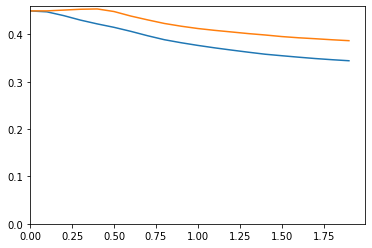

In [9]:
plt.plot(tlist, gas_mass)
plt.plot(tlist, gas_mass_barred)
plt.xlim(0, None)
plt.ylim(0, None)
plt.show()

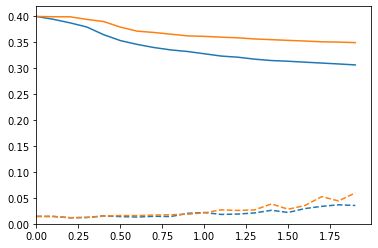

In [12]:
l = plt.plot(tlist, gas_mass_outR, label='R>2 kpc')
plt.plot(tlist, gas_mass_outR2, c=l[0].get_color(), label='R > 15 kpc', ls='dashed')
l = plt.plot(tlist, gas_mass_outR_barred)
plt.plot(tlist, gas_mass_outR2_barred, c=l[0].get_color(), label='R > 15 kpc', ls='dashed')
plt.xlim(0, None)
plt.ylim(0, None)
plt.show()

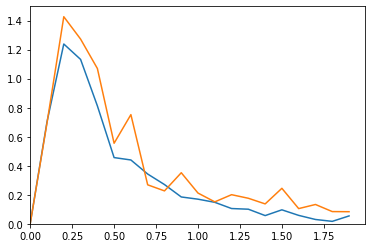

In [11]:
plt.plot(tlist, sfr_outR)
plt.plot(tlist, sfr_outR_barred)
plt.xlim(0, None)
plt.ylim(0, None)
plt.show()

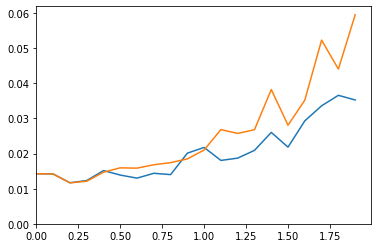

In [13]:
plt.plot(tlist, gas_mass_outR2)
plt.plot(tlist, gas_mass_outR2_barred)
plt.xlim(0, None)
plt.ylim(0, None)
plt.show()

In [6]:
sn = read_snap(150, 0, lvl='lvl4', fields=['Coordinates', 'Masses', 'StarFormationRate', 'InternalEnergy', 'ElectronAbundance'])
n, T = get_n_T(sn.part0.mass, sn.part0.u, sn.part0.ne)

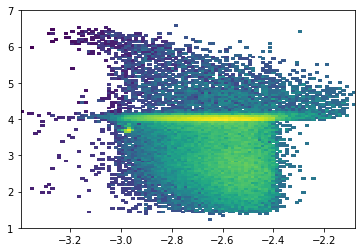

In [9]:
from matplotlib.colors import LogNorm
logT = np.log10(T)
logn = np.log10(n)
plt.hist2d(np.array(logn), np.array(logT), bins=100, weights=sn.part0.mass, norm=LogNorm())
# plt.xlim(-6, 8)
plt.ylim(1, 7)
plt.show()

## Remaking the Big Disk Plot - lvl4

In [5]:
def disk_decomp(idx_list, snap_idx, lvl='lvl4', prop='mass', Rcut=15.0, Rcut2=30.0, zmax=3, center=np.array([200, 200, 200])):
    tlist = []
    tot_gas = []
    in_disk = []
    in_bigdisk = []
    out_disk = []
    in_star = []
    for idx in tqdm(idx_list):
        sn = read_snap(idx, snap_idx, lvl=lvl, parttype=[0,4], fields=['Coordinates', 'Masses', 'StarFormationRate'])
        
        tlist.append(sn.Time)
        
        pos = sn.part0.pos - center
        R = np.linalg.norm(pos[:,:2], axis=1)
        z = np.abs(pos[:,2])
        
        key_in_disk = np.logical_and(R < Rcut, z < zmax)
        key_in_bigdisk = np.logical_and(np.logical_and(R > Rcut, R < Rcut2), z < zmax)
        key_out_disk = np.logical_or(R > Rcut2, z > zmax)
        
        qty = getattr(sn.part0, prop)
        
        tot_gas.append(np.sum(qty))
        in_disk.append(np.sum(qty[key_in_disk]))
        in_bigdisk.append(np.sum(qty[key_in_bigdisk]))
        out_disk.append(np.sum(qty[key_out_disk]))
        
        if sn.NumPart_Total[4] > 0.0:
            in_star.append(np.sum(sn.part4.mass))
        else:
            in_star.append(0.)
    
    return np.array(tlist), np.array(tot_gas), np.array(in_disk), np.array(in_bigdisk), np.array(out_disk), np.array(in_star)


In [11]:
tlist, tot_gas, in_disk, in_bigdisk, out_disk, in_star = disk_decomp(np.arange(0, 1000, 10), 0, Rcut=16.5, zmax=4)
tlist_b, tot_gas_b, in_disk_b, in_bigdisk_b, out_disk_b, in_star_b = disk_decomp(np.arange(0, 1000, 10), 1, Rcut=16.5, zmax=4)
tlist_s, tot_gas_s, in_disk_s, in_bigdisk_s, out_disk_s, in_star_s = disk_decomp(np.arange(0, 1000, 10), 2, Rcut=16.5, zmax=4)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [12]:
tlist, tot_sfr, sfr_in_disk, sfr_in_bigdisk, sfr_out_disk, sfr_in_star = disk_decomp(np.arange(0, 1000, 10), 0, Rcut=16.5, zmax=4, prop='sfr')
tlist_b, tot_sfr_b, sfr_in_disk_b, sfr_in_bigdisk_b, sfr_out_disk_b, sfr_in_star_b = disk_decomp(np.arange(0, 1000, 10), 1, Rcut=16.5, zmax=4, prop='sfr')
tlist_s, tot_sfr_s, sfr_in_disk_s, sfr_in_bigdisk_s, sfr_out_disk_s, sfr_in_star_s = disk_decomp(np.arange(0, 1000, 10), 2, Rcut=16.5, zmax=4, prop='sfr')

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

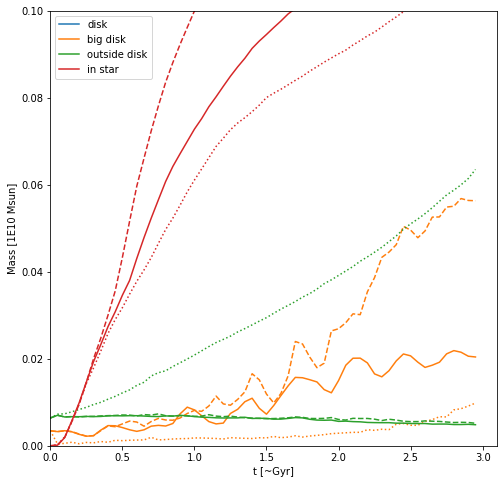

In [25]:
tot_mass = in_disk + in_bigdisk + out_disk + in_star

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

l = ax.plot(tlist, in_disk, label='disk')
ax.plot(tlist_b, in_disk_b, c=l[0].get_color(), ls='dashed')
ax.plot(tlist_s, in_disk_s, c=l[0].get_color(), ls='dotted')

l = ax.plot(tlist, in_bigdisk, label='big disk')
ax.plot(tlist_b, in_bigdisk_b, c=l[0].get_color(), ls='dashed')
ax.plot(tlist_s, in_bigdisk_s, c=l[0].get_color(), ls='dotted')

l = ax.plot(tlist, out_disk, label='outside disk')
ax.plot(tlist_b, out_disk_b, c=l[0].get_color(), ls='dashed')
ax.plot(tlist_s, out_disk_s, c=l[0].get_color(), ls='dotted')

l = ax.plot(tlist, in_star, label='in star')
ax.plot(tlist_b, in_star_b, c=l[0].get_color(), ls='dashed')
ax.plot(tlist_s, in_star_s, c=l[0].get_color(), ls='dotted')

ax.legend()
ax.set(xlim=(0, None), ylim=(0, 0.1), xlabel='t [~Gyr]', ylabel='Mass [1E10 Msun]')
plt.show()

In [14]:
(out_disk_s[-1]-out_disk_s[0]) / (tlist_s[-1]-tlist_s[0])

0.019371218335664023

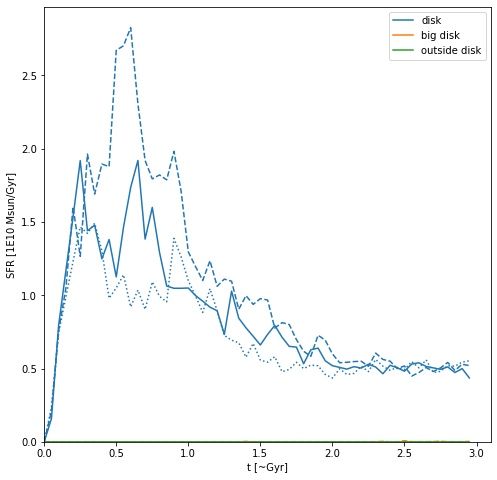

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

l = ax.plot(tlist, sfr_in_disk, label='disk')
ax.plot(tlist_b, sfr_in_disk_b, c=l[0].get_color(), ls='dashed')
ax.plot(tlist_s, sfr_in_disk_s, c=l[0].get_color(), ls='dotted')

l = ax.plot(tlist, sfr_in_bigdisk, label='big disk')
ax.plot(tlist_b, sfr_in_bigdisk_b, c=l[0].get_color(), ls='dashed')
ax.plot(tlist_s, sfr_in_bigdisk_s, c=l[0].get_color(), ls='dotted')

l = ax.plot(tlist, sfr_out_disk, label='outside disk')
ax.plot(tlist_b, sfr_out_disk_b, c=l[0].get_color(), ls='dashed')
ax.plot(tlist_s, sfr_out_disk_s, c=l[0].get_color(), ls='dotted')

ax.legend()
ax.set(xlim=(0, None), ylim=(0, None), xlabel='t [~Gyr]', ylabel='SFR [1E10 Msun/Gyr]')
plt.show()

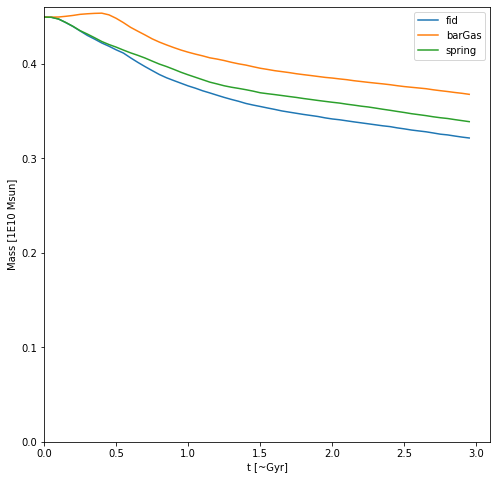

In [16]:
tot_mass = in_disk + in_bigdisk + out_disk + in_star

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.plot(tlist, tot_gas, label='fid')
ax.plot(tlist_b, tot_gas_b, label='barGas')
ax.plot(tlist_s, tot_gas_s, label='spring')

ax.legend()
ax.set(xlim=(0, None), ylim=(0, None), xlabel='t [~Gyr]', ylabel='Mass [1E10 Msun]')
plt.show()

## Remaking the Big Disk Plot - lvl3

In [6]:
tlist3, tot_gas3, in_disk3, in_bigdisk3, out_disk3, in_star3 = disk_decomp(np.arange(0, 600, 20), 0, Rcut=16.5, zmax=4, lvl='lvl3')
tlist_b3, tot_gas_b3, in_disk_b3, in_bigdisk_b3, out_disk_b3, in_star_b3 = disk_decomp(np.arange(0, 600, 20), 1, Rcut=16.5, zmax=4, lvl='lvl3')
tlist_s3, tot_gas_s3, in_disk_s3, in_bigdisk_s3, out_disk_s3, in_star_s3 = disk_decomp(np.arange(0, 450, 20), 2, Rcut=16.5, zmax=4, lvl='lvl3')

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [7]:
tlist3, tot_sfr3, sfr_in_disk3, sfr_in_bigdisk3, sfr_out_disk3, sfr_in_star3 = disk_decomp(np.arange(0, 600, 20), 0, Rcut=16.5, zmax=4, prop='sfr', lvl='lvl3')
tlist_b3, tot_sfr_b3, sfr_in_disk_b3, sfr_in_bigdisk_b3, sfr_out_disk_b3, sfr_in_star_b3 = disk_decomp(np.arange(0, 600, 20), 1, Rcut=16.5, zmax=4, prop='sfr', lvl='lvl3')
tlist_s3, tot_sfr_s3, sfr_in_disk_s3, sfr_in_bigdisk_s3, sfr_out_disk_s3, sfr_in_star_s3 = disk_decomp(np.arange(0, 450, 20), 2, Rcut=16.5, zmax=4, prop='sfr', lvl='lvl3')

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

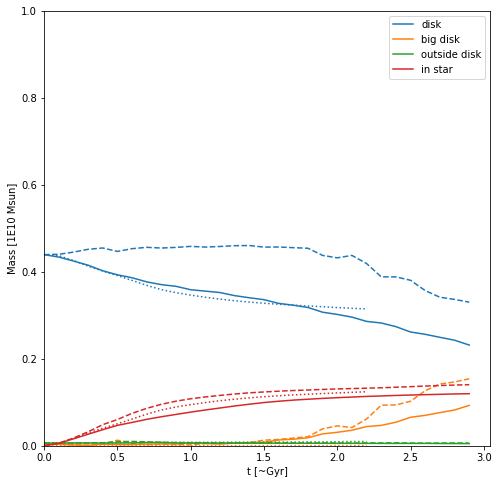

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

l = ax.plot(tlist3, in_disk3, label='disk')
ax.plot(tlist_b3, in_disk_b3, c=l[0].get_color(), ls='dashed')
ax.plot(tlist_s3, in_disk_s3, c=l[0].get_color(), ls='dotted')

l = ax.plot(tlist3, in_bigdisk3, label='big disk')
ax.plot(tlist_b3, in_bigdisk_b3, c=l[0].get_color(), ls='dashed')
ax.plot(tlist_s3, in_bigdisk_s3, c=l[0].get_color(), ls='dotted')

l = ax.plot(tlist3, out_disk3, label='outside disk')
ax.plot(tlist_b3, out_disk_b3, c=l[0].get_color(), ls='dashed')
ax.plot(tlist_s3, out_disk_s3, c=l[0].get_color(), ls='dotted')

l = ax.plot(tlist3, in_star3, label='in star')
ax.plot(tlist_b3, in_star_b3, c=l[0].get_color(), ls='dashed')
ax.plot(tlist_s3, in_star_s3, c=l[0].get_color(), ls='dotted')

ax.legend()
ax.set(xlim=(0, None), ylim=(0, 1.0), xlabel='t [~Gyr]', ylabel='Mass [1E10 Msun]')
plt.show()

In [20]:
(out_disk_s[-1]-out_disk_s[0]) / (tlist_s[-1]-tlist_s[0])

NameError: name 'out_disk_s' is not defined

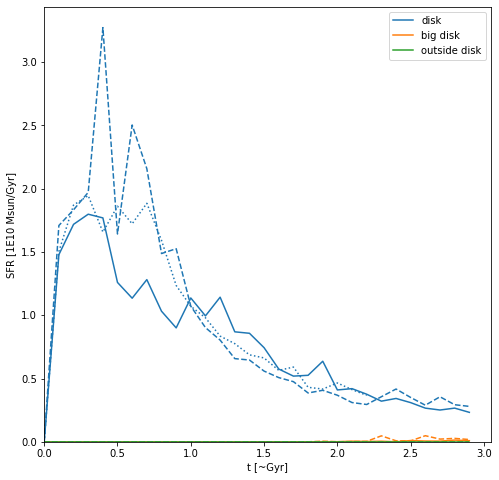

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

l = ax.plot(tlist3, sfr_in_disk3, label='disk')
ax.plot(tlist_b3, sfr_in_disk_b3, c=l[0].get_color(), ls='dashed')
ax.plot(tlist_s3, sfr_in_disk_s3, c=l[0].get_color(), ls='dotted')

l = ax.plot(tlist3, sfr_in_bigdisk3, label='big disk')
ax.plot(tlist_b3, sfr_in_bigdisk_b3, c=l[0].get_color(), ls='dashed')
ax.plot(tlist_s3, sfr_in_bigdisk_s3, c=l[0].get_color(), ls='dotted')

l = ax.plot(tlist3, sfr_out_disk3, label='outside disk')
ax.plot(tlist_b3, sfr_out_disk_b3, c=l[0].get_color(), ls='dashed')
ax.plot(tlist_s3, sfr_out_disk_s3, c=l[0].get_color(), ls='dotted')

ax.legend()
ax.set(xlim=(0, None), ylim=(0, None), xlabel='t [~Gyr]', ylabel='SFR [1E10 Msun/Gyr]')
plt.show()

### Global Star Formation Rate

In [4]:
sfr4 = read_sfr(0, lvl='lvl4')
sfr_b4 = read_sfr(1, lvl='lvl4')
sfr_s4 = read_sfr(2, lvl='lvl4')

sfr3 = read_sfr(0, lvl='lvl3')
sfr_b3 = read_sfr(1, lvl='lvl3')
sfr_s3 = read_sfr(2, lvl='lvl3')
sfr_MB3 = read_sfr(3, lvl='lvl3')
sfr_LM103 = read_sfr(4, lvl='lvl3')
sfr_LM33 = read_sfr(5, lvl='lvl3')
sfr_WF3 = read_sfr(6, lvl='lvl3')

In [5]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/IPython/core/pylabtools.py:121: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


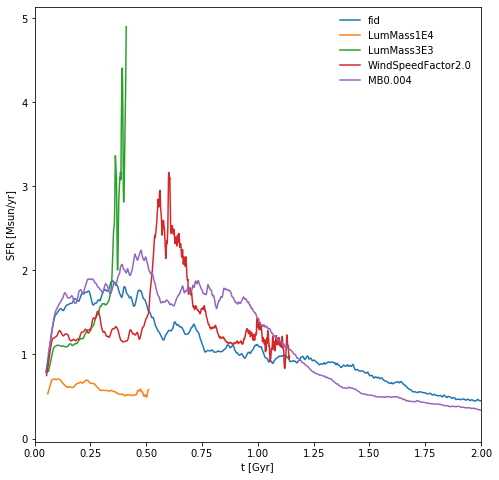

In [11]:
window = 4000

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

l0 = ax.plot(moving_average(sfr3[:,0], window), moving_average(sfr3[:,2], window), label='fid')
# l1 = ax.plot(moving_average(sfr_b3[:,0], window), moving_average(sfr_b3[:,2], window), label='barGas')
# l2 = ax.plot(moving_average(sfr_s3[:,0], window), moving_average(sfr_s3[:,2], window), label='spring')
l4 = ax.plot(moving_average(sfr_LM103[:,0], window), moving_average(sfr_LM103[:,2], window), label='LumMass1E4')
l4 = ax.plot(moving_average(sfr_LM33[:,0], window), moving_average(sfr_LM33[:,2], window), label='LumMass3E3')
l4 = ax.plot(moving_average(sfr_WF3[:,0], window), moving_average(sfr_WF3[:,2], window), label='WindSpeedFactor2.0')
l3 = ax.plot(moving_average(sfr_MB3[:,0], window), moving_average(sfr_MB3[:,2], window), label='MB0.004')



# ax.plot(moving_average(sfr4[:,0], window), moving_average(sfr4[:,2], window), ls='dashed', c=l0[0].get_color(), alpha=0.5)
# ax.plot(moving_average(sfr_b4[:,0], window), moving_average(sfr_b4[:,2], window), ls='dashed', c=l1[0].get_color(), alpha=0.5)
# ax.plot(moving_average(sfr_s4[:,0], window), moving_average(sfr_s4[:,2], window), ls='dashed', c=l2[0].get_color(), alpha=0.5)

ax.legend(frameon=False)
ax.set(xlabel='t [Gyr]', ylabel='SFR [Msun/yr]')
ax.set_xlim(0, 2)
plt.show()

In [38]:
sn = read_snap(200, 0, parttype=[0, 3, 4], fields=['Coordinates', 'Masses', 'StarFormationRate'])

1.0


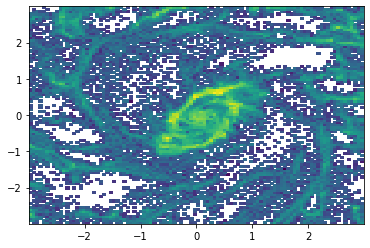

In [32]:
import matplotlib as mpl
xmin = -3
xmax = 3
ymin = -3
ymax = 3

pos = sn.part0.pos - np.array([200, 200, 200])

xbool = np.logical_and(pos[:,0] > xmin, pos[:,0] < xmax)
ybool = np.logical_and(pos[:,1] > ymin, pos[:,1] < ymax)
key = np.logical_and(xbool, ybool)

plt.hist2d(pos[:,0][key], pos[:,1][key], bins=100, weights=sn.part0.mass[key], norm=mpl.colors.LogNorm())
print(sn.Time)
plt.show()

1.0


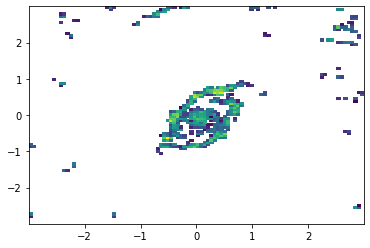

In [33]:
import matplotlib as mpl
xmin = -3
xmax = 3
ymin = -3
ymax = 3

pos = sn.part0.pos - np.array([200, 200, 200])

xbool = np.logical_and(pos[:,0] > xmin, pos[:,0] < xmax)
ybool = np.logical_and(pos[:,1] > ymin, pos[:,1] < ymax)
key = np.logical_and(xbool, ybool)

plt.hist2d(pos[:,0][key], pos[:,1][key], bins=100, weights=sn.part0.sfr[key], norm=mpl.colors.LogNorm())
print(sn.Time)
plt.show()

1.0


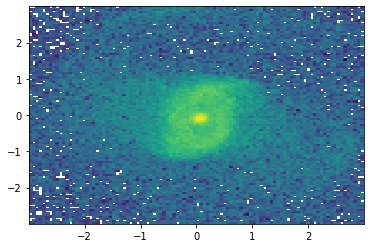

In [35]:
import matplotlib as mpl
xmin = -3
xmax = 3
ymin = -3
ymax = 3

pos = sn.part4.pos - np.array([200, 200, 200])

xbool = np.logical_and(pos[:,0] > xmin, pos[:,0] < xmax)
ybool = np.logical_and(pos[:,1] > ymin, pos[:,1] < ymax)
key = np.logical_and(xbool, ybool)

plt.hist2d(pos[:,0][key], pos[:,1][key], bins=100, weights=sn.part4.mass[key], norm=mpl.colors.LogNorm())
print(sn.Time)
plt.show()

In [39]:

pos_bulge = sn.part3.pos - np.array([200, 200, 200])
pos_star = sn.part4.pos - np.array([200, 200, 200])

r_blg = np.linalg.norm(pos_bulge, axis=1)
r_star = np.linalg.norm(pos_star, axis=1)

print(np.sum(sn.MassTable[3]*len(np.where(r_blg<1.0)[0])))
print(np.sum(sn.part4.mass[r_star < 1.0]))

0.462227405577549
0.021329073


## Surface Density Plots

In [12]:
# first get snapshots at intervals of 100 snaps (~ 500 Myr)
sn0_list = []
sn1_list = []
sn2_list = []
sn3_list = []
sn4_list = []

idx_list = np.array([0, 50, 100, 150, 200, 300, 400, 500, 600, 700, 800])

for idx in tqdm(idx_list):
    try:
        sn0 = read_snap(idx, 0, parttype=[0, 2, 3, 4], fields=['Coordinates', 'Masses', 'Velocities', 'StarFormationRate', 'NeutralHydrogenAbundance'])
        sn0_list.append(sn0)
    except:
        pass

    try:
        sn1 = read_snap(idx, 1, parttype=[0, 2, 3, 4], fields=['Coordinates', 'Masses', 'Velocities', 'StarFormationRate', 'NeutralHydrogenAbundance'])
        sn1_list.append(sn1)
    except:
        pass

    try:
        sn2 = read_snap(idx, 2, parttype=[0, 2, 3, 4], fields=['Coordinates', 'Masses', 'Velocities', 'StarFormationRate', 'NeutralHydrogenAbundance'])
        sn2_list.append(sn2)
    except:
        pass

    try:
        sn3 = read_snap(idx, 3, parttype=[0, 2, 3, 4], fields=['Coordinates', 'Masses', 'Velocities', 'StarFormationRate', 'NeutralHydrogenAbundance'])
        sn3_list.append(sn3)
    except:
        pass
    
    try:
        sn4 = read_snap(idx, 4, parttype=[0, 2, 3, 4], fields=['Coordinates', 'Masses', 'Velocities', 'StarFormationRate', 'NeutralHydrogenAbundance'])
        sn4_list.append(sn4)
    except:
        pass

A Jupyter Widget

In [11]:
def my_bin(X, Xbins, Y, func=np.mean):
    Xmin = Xbins[0]
    Xmax = Xbins[-1]
    assert Xmin==np.min(Xbins), "First entry of Xbins is not the min value"
    assert Xmax==np.max(Xbins), "Last entry of Xbins is not the max value"

    keys = np.logical_and(X > Xmin, X < Xmax)

    digit = np.digitize(X[keys], Xbins)
    X_avg = [X[keys][digit == i].mean() for i in range(1, len(Xbins))]
    Y_func = [func(Y[keys][digit == i]) for i in range(1, len(Xbins))]

    return np.array(X_avg), np.array(Y_func)

def compute_sfr_profile(sn, center=[200, 200, 200],
                        Rmin=0.1, Rmax=20, nbins=20):

    #get pos of gas
    pos = np.subtract(sn.part0.pos, center)
    R = np.linalg.norm(pos[:,:2], axis=1)
    sfr = np.copy(sn.part0.sfr.value) # Msun/yr

    #do binning
    bins = np.logspace(np.log10(Rmin), np.log10(Rmax), nbins)
#     bins = np.linspace(Rmin, Rmax, nbins)
    R_binned, tot_sfr_binned = my_bin(R, bins, sfr, np.sum)

    # now go through and divide by area of bin
    for i in range(len(R_binned)):
        surf_area = np.pi * (bins[i+1]**2 - bins[i]**2) * (1E6) # 1E6 converts to Msun/yr/pc^2
        tot_sfr_binned[i] /= surf_area
        tot_sfr_binned[i] *= 1E9 # conerts to Msun/pc^2/Gyr

    return R_binned, tot_sfr_binned

def compute_gas_profile(sn, center=[200, 200, 200],
                        Rmin=0.1, Rmax=20, nbins=20):

    #get pos of gas
    pos = np.subtract(sn.part0.pos, center)
    R = np.linalg.norm(pos[:,:2], axis=1)
    gas_mass = 1E10 * np.copy(sn.part0.mass.value)

    #do binning
    bins = np.logspace(np.log10(Rmin), np.log10(Rmax), nbins)
#     bins = np.linspace(Rmin, Rmax, nbins)
    R_binned, tot_sfr_binned = my_bin(R, bins, gas_mass, np.sum)

    # now go through and divide by area of bin
    for i in range(len(R_binned)):
        surf_area = np.pi * (bins[i+1]**2 - bins[i]**2) * (1E6) # 1E6 converts to Msun/pc^2
        tot_sfr_binned[i] /= surf_area
        
    return R_binned, tot_sfr_binned

def compute_HI_profile(sn, center=[200, 200, 200],
                        Rmin=0.1, Rmax=20, nbins=20):

    #get pos of gas
    pos = np.subtract(sn.part0.pos, center)
    R = np.linalg.norm(pos[:,:2], axis=1)
    gas_mass = 1E10 * np.copy(sn.part0.mass.value) * sn.part0.NeutralHydrogenAbundance

    #do binning
    bins = np.logspace(np.log10(Rmin), np.log10(Rmax), nbins)
#     bins = np.linspace(Rmin, Rmax, nbins)
    R_binned, tot_sfr_binned = my_bin(R, bins, gas_mass, np.sum)

    # now go through and divide by area of bin
    for i in range(len(R_binned)):
        surf_area = np.pi * (bins[i+1]**2 - bins[i]**2) * (1E6) # 1E6 converts to Msun/pc^2
        tot_sfr_binned[i] /= surf_area
        
    return R_binned, tot_sfr_binned

def compute_HI_vol_dens(sn, center=[200, 200, 200],
                        Rsun=8.2, dR=0.1, dz=0.2):
    pos = np.subtract(sn.part0.pos, center)
    R = np.linalg.norm(pos[:,:2], axis=1)
    z = pos[:,2]
    gas_mass = 1E10 * np.copy(sn.part0.mass.value) * sn.part0.NeutralHydrogenAbundance
    
    Rbool = np.abs(R-Rsun) < dR
    zbool = np.abs(z) < dz
    
    tot_mass = np.sum(gas_mass[np.logical_and(Rbool, zbool)])
    tot_vol = (np.pi*(Rsun+dR)**2 - np.pi*(Rsun-dR)**2) * (2. * dz) # in kpc^3
    tot_vol *= 1E9 # in pc^3
    
    return tot_mass/tot_vol

def compute_star_vol_dens(sn, center=[200, 200, 200],
                        Rsun=8.2, dR=0.1, dz=0.2):
    
    star_mass = 0
    for i in [2, 3, 4]:
        if sn.NumPart_Total[i] > 0:
            part = getattr(sn, 'part'+str(i))
            pos = np.subtract(part.pos, center)
            R = np.linalg.norm(pos[:,:2], axis=1)
            z = pos[:,2]
            try:
                mass = 1E10 * np.copy(part.mass.value)
            except:
                mass = 1E10 * np.full(sn.NumPart_Total[i], sn.MassTable[i])
    
            Rbool = np.abs(R-Rsun) < dR
            zbool = np.abs(z) < dz
    
            star_mass += np.sum(mass[np.logical_and(Rbool, zbool)])
    
    tot_vol = (np.pi*(Rsun+dR)**2 - np.pi*(Rsun-dR)**2) * (2. * dz) # in kpc^3
    tot_vol *= 1E9 # in pc^3
    
    return star_mass/tot_vol
    

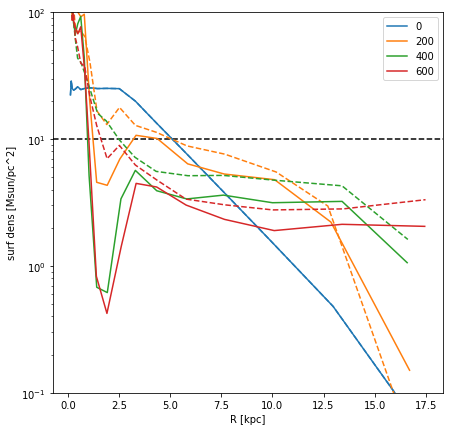

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(7,7))

ax.axhline(10, c='k', ls='dashed')



for i,idx in enumerate(idx_list):
    if idx not in [0, 200, 400, 600]:#, 400, 600]:
        continue
    
    R0, gas0 = compute_HI_profile(sn0_list[i])
    l = ax.plot(R0, gas0, label=str(idx))
    try:
        R1, gas1 = compute_HI_profile(sn1_list[i])
        ax.plot(R1, gas1, c=l[0].get_color(), ls='dashed')
    except:
        pass
    
    try:
        R2, gas2 = compute_HI_profile(sn2_list[i])
#         ax.plot(R2, gas2, c=l[0].get_color(), ls='dotted')
    except:
        pass

ax.set(yscale='log', ylim=(0.1, 100), xlabel='R [kpc]', ylabel='surf dens [Msun/pc^2]')
ax.legend()
plt.show()

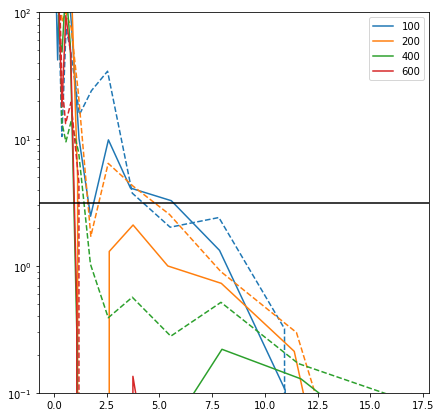

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(7,7))
nbins=15

for i,idx in enumerate(idx_list):
    if idx not in [100, 200, 400, 600]:#, 200, 300]:#, 400, 600]:
        continue
    
    R0, sfr0 = compute_sfr_profile(sn0_list[i], nbins=nbins)
    l = ax.plot(R0, sfr0, label=str(idx))
    try:
        R1, sfr1 = compute_sfr_profile(sn1_list[i], nbins=nbins)
        ax.plot(R1, sfr1, c=l[0].get_color(), ls='dashed')
    except:
        pass
    
    try:
        R2, sfr2 = compute_sfr_profile(sn2_list[i], nbins=nbins)
#         ax.plot(R2, sfr2, c=l[0].get_color(), ls='dotted')
    except:
        pass
    
    try:
        R3, sfr3 = compute_sfr_profile(sn3_list[i], nbins=nbins)
#         ax.plot(R3, sfr3, c=l[0].get_color(), ls='dotted', label='name')
#         ax.plot(R3, sfr3, label='LumMass1E3')
    except:
        pass
    
    try:
        R4, sfr4 = compute_sfr_profile(sn4_list[i], nbins=nbins)
#         ax.plot(R4, sfr4, c=l[0].get_color(), ls='dotted')
#         ax.plot(R4, sfr4, label='LumMass1E4')
    except:
        pass

ax.set(yscale='log', ylim=(0.1, 100))
ax.axhline(10.**(0.5), c='k')
ax.legend()
plt.show()

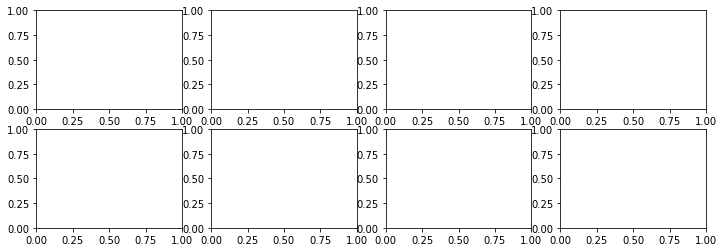

In [89]:
fig, ax = plt.subplots(2, 4, figsize=(12, 4))

plt.show()

In [26]:
for i,idx in enumerate(idx_list):
    try:
        print(idx, compute_HI_vol_dens(sn0_list[i], dz=0.1)/1E-3, compute_star_vol_dens(sn0_list[i], dz=0.1)/1E-3)
    except:
        pass

0 5.905563529632121 68.2164112213961
50 26.605481544638142 75.59825358548066
100 13.558390192859221 84.65302151206399
150 16.41554167215888 80.47653617719303
200 16.171716299342094 64.54172231562077
300 11.407356791381922 59.3672758412208
400 9.012090425160407 58.15679395212258
500 10.06007429120113 59.00107732799922
600 8.256552796594075 57.39674115785762
700 8.236955388540432 60.38020749936039


In [102]:
compute_star_vol_dens(sn0_list[0], dz=0.1)/1E-3

68.2164112213961